In [7]:
import os
import http
import copy
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import backwardcompatibilityml.loss as bcloss
import backwardcompatibilityml.scores as scores
from backwardcompatibilityml.helpers import training
from backwardcompatibilityml.helpers import training_binary
from backwardcompatibilityml.helpers import utils
from backwardcompatibilityml.widget.compatibility_analysis import CompatibilityAnalysis

# Turn off warnings so that the widget screen
# real estate does not decrease.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
if not os.path.isdir("datasets/adult-uci"):
    os.mkdir("datasets/adult-uci")

http_client = http.client.HTTPSConnection("archive.ics.uci.edu")
http_client.request("GET", "/ml/machine-learning-databases/adult/adult.data")
response = http_client.getresponse()
data = response.read().decode("utf-8")
data_file = open("datasets/adult-uci/adult.data", "w")
data_file.write(data)
data_file.close()

In [9]:
datafile = open("datasets/adult-uci/adult.data", "r")
raw_data = datafile.read()
datafile.close()

In [10]:
import pandas as pd
df = pd.read_csv("datasets/adult-uci/adult.data")

In [11]:
rows_with_header = list(map(lambda l: list(map(lambda ll: ll.strip(), l.split(","))), filter(lambda l: len(l) > 0, map(lambda l: l.strip(), raw_data.split("\n")))))
data_rows = rows_with_header[1:]
data_rows = list(filter(lambda r: ("?" not in r), data_rows))
# data_rows_transformed = list(map(lambda r: [torch.tensor(int(r[0]), dtype=torch.long), torch.tensor(list(map(lambda i: int(i), r[1:])), dtype=torch.float32)], data_rows))
# random.shuffle(data_rows_transformed)

In [12]:
def build_categorical_encoder(input_attribute_index, categories, total_dimensions, start_index, end_index):
    if not (end_index - start_index + 1 == len(categories)):
        raise Exception("Mismatch between number of categories and dimensions assigned.")
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        
        category_index = categories.index(data_row[input_attribute_index])
        encoding_index = start_index + category_index
        data_vector[encoding_index] = 1
    
    return encoder

def build_continuous_encoder(input_attribute_index, total_dimensions, attribute_index):
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        data_vector[attribute_index] = float(data_row[input_attribute_index])
    
    return encoder

def encode_data(rows, encoders, total_dimensions):
    encoded_rows = []
    for row in rows:
        encoded_row = [0] * total_dimensions
        for encoder in encoders:
            encoder(row, encoded_row)
        encoded_rows.append(encoded_row)
    
    return encoded_rows

In [13]:
total_dim = 105
workingclass_classes = ["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked"]
education_classes = ["Bachelors", "Some-college", "11th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters", "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool"]
maritalstatus_classes = ["Married-civ-spouse", "Divorced", "Never-married", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"]
occupation_classes = ["Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces"]
relationship_classes = ["Wife", "Own-child", "Husband", "Not-in-family", "Other-relative", "Unmarried"]
race_classes = ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"]
sex_classes = ["Female", "Male"]
nativecountry_classes = ["United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"]
income_classes = ["<=50K", ">50K"]


age_encoder = build_continuous_encoder(0, total_dim, 0)
workingclass_encoder = build_categorical_encoder(1, workingclass_classes, total_dim, 1, 8)
fnlwgt_encoder = build_continuous_encoder(2, total_dim, 9)
education_encoder = build_categorical_encoder(3, education_classes, total_dim, 10, 25)
educationnum_encoder = build_continuous_encoder(4, total_dim, 26)
maritalstatus_encoder = build_categorical_encoder(5, maritalstatus_classes, total_dim, 27, 33)
occupation_encoder = build_categorical_encoder(6, occupation_classes, total_dim, 34, 47)
relationship_encoder = build_categorical_encoder(7, relationship_classes, total_dim, 48, 53)
race_encoder = build_categorical_encoder(8, race_classes, total_dim, 54, 58)
sex_encoder = build_categorical_encoder(9, sex_classes, total_dim, 59, 60)
capitalgain_encoder = build_continuous_encoder(10, total_dim, 61)
capitalloss_encoder = build_continuous_encoder(11, total_dim, 62)
hoursperweek_encoder = build_continuous_encoder(12, total_dim, 63)
nativecountry_encoder = build_categorical_encoder(13, nativecountry_classes, total_dim, 64, 104)

data_encoders = [
    age_encoder,
    workingclass_encoder,
    fnlwgt_encoder,
    education_encoder,
    educationnum_encoder,
    maritalstatus_encoder,
    occupation_encoder,
    relationship_encoder,
    race_encoder,
    sex_encoder,
    nativecountry_encoder
]

income_encoder = build_categorical_encoder(14, income_classes, 2, 0, 1)

target_encoders = [income_encoder]

In [14]:
encoded_data_rows = encode_data(data_rows, data_encoders, total_dim)
encoded_target_rows = encode_data(data_rows, target_encoders, 2)
encoded_data = list(zip(encoded_data_rows, encoded_target_rows))
random.shuffle(encoded_data)

In [15]:
data_rows_transformed = list(map(lambda r: (torch.tensor(r[0]), torch.tensor(np.argmax(r[1]), dtype=torch.float32)), encoded_data))

In [16]:
training_set = data_rows_transformed[:24128]
testing_set = data_rows_transformed[24128:]

In [17]:
train_loader = []
prev = 0
for i in range((batch_size_train - 1), len(training_set), batch_size_train):
    training_data = list(map(lambda r: r[0], training_set[prev:i]))
    training_labels = list(map(lambda r: r[1], training_set[prev:i]))
    prev = i
    train_loader.append([torch.stack(training_data, dim=0), torch.stack(training_labels, dim=0)])

test_loader = []
prev = 0
for i in range((batch_size_test - 1), len(testing_set), batch_size_test):
    testing_data = list(map(lambda r: r[0], testing_set[prev:i]))
    testing_labels = list(map(lambda r: r[1], testing_set[prev:i]))
    prev = i
    test_loader.append([torch.stack(testing_data, dim=0), torch.stack(testing_labels, dim=0)])

In [18]:
n_epochs = 20
batch_size_train = 754
batch_size_test = 6033
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [19]:
train_loader_a = train_loader[:int(len(train_loader)/2)]
train_loader_b = train_loader[int(len(train_loader)/2):]

In [20]:
class LogisticRegression(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        out_sigmoid = F.sigmoid(out)

        return out_sigmoid

In [21]:
network = LogisticRegression(105, 1)
discriminant_pivot = 0.3
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [27]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader_a)*batch_size_train for i in range(n_epochs + 1)]

In [28]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader_a):
        optimizer.zero_grad()
        output_sigmoid = network(data)
        loss = F.binary_cross_entropy(output_sigmoid, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_a)*batch_size_train,
                100. * batch_idx / len(train_loader_a), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader_a)*batch_size_train))

In [29]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output_sigmoid = network(data)
            test_loss += F.binary_cross_entropy(output_sigmoid, target, reduction="sum").item()
            pred = utils.sigmoid_to_labels(output_sigmoid, discriminant_pivot=discriminant_pivot)
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(train_loader_a)*batch_size_train
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(train_loader_a)*batch_size_train,
            100. * correct / (len(train_loader_a)*batch_size_train)))

In [30]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 1.0377, Accuracy: 4528/141752 (3%)

Train Epoch: 1 [0/141752 (0%)]	Loss: 19.047619
Train Epoch: 1 [640/141752 (5%)]	Loss: 28.125000
Train Epoch: 1 [1280/141752 (11%)]	Loss: 17.187500
Train Epoch: 1 [1920/141752 (16%)]	Loss: 25.000000
Train Epoch: 1 [2560/141752 (21%)]	Loss: 37.500000
Train Epoch: 1 [3200/141752 (27%)]	Loss: 12.500000
Train Epoch: 1 [3840/141752 (32%)]	Loss: 26.562500
Train Epoch: 1 [4480/141752 (37%)]	Loss: 23.437500
Train Epoch: 1 [5120/141752 (43%)]	Loss: 20.312500
Train Epoch: 1 [5760/141752 (48%)]	Loss: 17.187500
Train Epoch: 1 [6400/141752 (53%)]	Loss: 39.062500
Train Epoch: 1 [7040/141752 (59%)]	Loss: 23.437500
Train Epoch: 1 [7680/141752 (64%)]	Loss: 31.250000
Train Epoch: 1 [8320/141752 (69%)]	Loss: 25.000000
Train Epoch: 1 [8960/141752 (74%)]	Loss: 23.437500
Train Epoch: 1 [9600/141752 (80%)]	Loss: 39.062500
Train Epoch: 1 [10240/141752 (85%)]	Loss: 25.000000
Train Epoch: 1 [10880/141752 (90%)]	Loss: 25.000000
Train Epoch: 1 [11520/141752

Train Epoch: 9 [3200/141752 (27%)]	Loss: 12.500000
Train Epoch: 9 [3840/141752 (32%)]	Loss: 26.562500
Train Epoch: 9 [4480/141752 (37%)]	Loss: 23.437500
Train Epoch: 9 [5120/141752 (43%)]	Loss: 20.312500
Train Epoch: 9 [5760/141752 (48%)]	Loss: 17.187500
Train Epoch: 9 [6400/141752 (53%)]	Loss: 39.062500
Train Epoch: 9 [7040/141752 (59%)]	Loss: 23.437500
Train Epoch: 9 [7680/141752 (64%)]	Loss: 31.250000
Train Epoch: 9 [8320/141752 (69%)]	Loss: 25.000000
Train Epoch: 9 [8960/141752 (74%)]	Loss: 23.437500
Train Epoch: 9 [9600/141752 (80%)]	Loss: 39.062500
Train Epoch: 9 [10240/141752 (85%)]	Loss: 25.000000
Train Epoch: 9 [10880/141752 (90%)]	Loss: 25.000000
Train Epoch: 9 [11520/141752 (96%)]	Loss: 28.125000

Test set: Avg. loss: 1.0377, Accuracy: 4528/141752 (3%)

Train Epoch: 10 [0/141752 (0%)]	Loss: 19.047619
Train Epoch: 10 [640/141752 (5%)]	Loss: 28.125000
Train Epoch: 10 [1280/141752 (11%)]	Loss: 17.187500
Train Epoch: 10 [1920/141752 (16%)]	Loss: 25.000000
Train Epoch: 10 [2560/1

Train Epoch: 17 [4480/141752 (37%)]	Loss: 23.437500
Train Epoch: 17 [5120/141752 (43%)]	Loss: 20.312500
Train Epoch: 17 [5760/141752 (48%)]	Loss: 17.187500
Train Epoch: 17 [6400/141752 (53%)]	Loss: 39.062500
Train Epoch: 17 [7040/141752 (59%)]	Loss: 23.437500
Train Epoch: 17 [7680/141752 (64%)]	Loss: 31.250000
Train Epoch: 17 [8320/141752 (69%)]	Loss: 25.000000
Train Epoch: 17 [8960/141752 (74%)]	Loss: 23.437500
Train Epoch: 17 [9600/141752 (80%)]	Loss: 39.062500
Train Epoch: 17 [10240/141752 (85%)]	Loss: 25.000000
Train Epoch: 17 [10880/141752 (90%)]	Loss: 25.000000
Train Epoch: 17 [11520/141752 (96%)]	Loss: 28.125000

Test set: Avg. loss: 1.0377, Accuracy: 4528/141752 (3%)

Train Epoch: 18 [0/141752 (0%)]	Loss: 19.047619
Train Epoch: 18 [640/141752 (5%)]	Loss: 28.125000
Train Epoch: 18 [1280/141752 (11%)]	Loss: 17.187500
Train Epoch: 18 [1920/141752 (16%)]	Loss: 25.000000
Train Epoch: 18 [2560/141752 (21%)]	Loss: 37.500000
Train Epoch: 18 [3200/141752 (27%)]	Loss: 12.500000
Train Epo

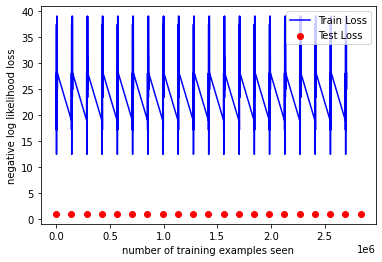

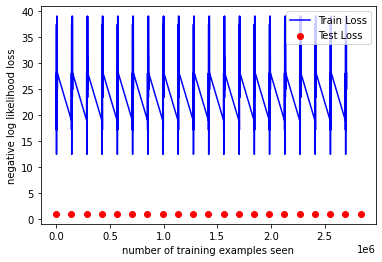

In [31]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [48]:
import copy

h1 = copy.deepcopy(network)
h2 = copy.deepcopy(network)
h1.eval()
new_optimizer = optim.SGD(h2.parameters(), lr=learning_rate, momentum=momentum)
lambda_c = 0.5
bc_loss = bcloss.BCBinaryCrossEntropyLoss(h1, h2, lambda_c, discriminant_pivot=discriminant_pivot)

In [49]:
update_train_losses = []
update_train_counter = []
update_test_losses = []
update_test_counter = [i*len(train_loader_b)*batch_size_train for i in range(n_epochs + 1)]

In [50]:
def train_update(epoch):
    for batch_idx, (data, target) in enumerate(train_loader_b):
        new_optimizer.zero_grad()
        loss = bc_loss(data, target)
        loss.backward()
        new_optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader_b)*batch_size_train,
                100. * batch_idx / len(train_loader_b), loss.item()))
            update_train_losses.append(loss.item())
            update_train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader_b)*batch_size_train))

In [51]:
def test_update():
    h2.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output_sigmoid = h2(data)
            test_loss += F.binary_cross_entropy(output_sigmoid, target, reduction="sum").item()
            pred = utils.sigmoid_to_labels(output_sigmoid, discriminant_pivot=discriminant_pivot)
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(train_loader_b)*batch_size_train
    update_test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(train_loader_b)*batch_size_train,
    100. * correct / (len(train_loader_b)*batch_size_train)))

In [52]:
test_update()
for epoch in range(1, n_epochs + 1):
    train_update(epoch)
    test_update()


Test set: Avg. loss: 1.0322, Accuracy: 4528/142506 (3%)

Train Epoch: 1 [0/142506 (0%)]	Loss: 28.125000
Train Epoch: 1 [640/142506 (5%)]	Loss: 29.687500
Train Epoch: 1 [1280/142506 (11%)]	Loss: 26.562500
Train Epoch: 1 [1920/142506 (16%)]	Loss: 23.437500
Train Epoch: 1 [2560/142506 (21%)]	Loss: 21.875000
Train Epoch: 1 [3200/142506 (26%)]	Loss: 32.812500
Train Epoch: 1 [3840/142506 (32%)]	Loss: 25.000000
Train Epoch: 1 [4480/142506 (37%)]	Loss: 46.875000
Train Epoch: 1 [5120/142506 (42%)]	Loss: 15.625000
Train Epoch: 1 [5760/142506 (48%)]	Loss: 28.125000
Train Epoch: 1 [6400/142506 (53%)]	Loss: 21.875000
Train Epoch: 1 [7040/142506 (58%)]	Loss: 25.000000
Train Epoch: 1 [7680/142506 (63%)]	Loss: 20.312500
Train Epoch: 1 [8320/142506 (69%)]	Loss: 29.687500
Train Epoch: 1 [8960/142506 (74%)]	Loss: 25.000000
Train Epoch: 1 [9600/142506 (79%)]	Loss: 23.437500
Train Epoch: 1 [10240/142506 (85%)]	Loss: 31.250000
Train Epoch: 1 [10880/142506 (90%)]	Loss: 26.562500
Train Epoch: 1 [11520/142506

Train Epoch: 9 [5760/142506 (48%)]	Loss: 28.125000
Train Epoch: 9 [6400/142506 (53%)]	Loss: 21.875000
Train Epoch: 9 [7040/142506 (58%)]	Loss: 25.000000
Train Epoch: 9 [7680/142506 (63%)]	Loss: 20.312500
Train Epoch: 9 [8320/142506 (69%)]	Loss: 29.687500
Train Epoch: 9 [8960/142506 (74%)]	Loss: 25.000000
Train Epoch: 9 [9600/142506 (79%)]	Loss: 23.437500
Train Epoch: 9 [10240/142506 (85%)]	Loss: 31.250000
Train Epoch: 9 [10880/142506 (90%)]	Loss: 26.562500
Train Epoch: 9 [11520/142506 (95%)]	Loss: 21.875000

Test set: Avg. loss: 1.0322, Accuracy: 4528/142506 (3%)

Train Epoch: 10 [0/142506 (0%)]	Loss: 28.125000
Train Epoch: 10 [640/142506 (5%)]	Loss: 29.687500
Train Epoch: 10 [1280/142506 (11%)]	Loss: 26.562500
Train Epoch: 10 [1920/142506 (16%)]	Loss: 23.437500
Train Epoch: 10 [2560/142506 (21%)]	Loss: 21.875000
Train Epoch: 10 [3200/142506 (26%)]	Loss: 32.812500
Train Epoch: 10 [3840/142506 (32%)]	Loss: 25.000000
Train Epoch: 10 [4480/142506 (37%)]	Loss: 46.875000
Train Epoch: 10 [51

Train Epoch: 18 [640/142506 (5%)]	Loss: 29.687500
Train Epoch: 18 [1280/142506 (11%)]	Loss: 26.562500
Train Epoch: 18 [1920/142506 (16%)]	Loss: 23.437500
Train Epoch: 18 [2560/142506 (21%)]	Loss: 21.875000
Train Epoch: 18 [3200/142506 (26%)]	Loss: 32.812500
Train Epoch: 18 [3840/142506 (32%)]	Loss: 25.000000
Train Epoch: 18 [4480/142506 (37%)]	Loss: 46.875000
Train Epoch: 18 [5120/142506 (42%)]	Loss: 15.625000
Train Epoch: 18 [5760/142506 (48%)]	Loss: 28.125000
Train Epoch: 18 [6400/142506 (53%)]	Loss: 21.875000
Train Epoch: 18 [7040/142506 (58%)]	Loss: 25.000000
Train Epoch: 18 [7680/142506 (63%)]	Loss: 20.312500
Train Epoch: 18 [8320/142506 (69%)]	Loss: 29.687500
Train Epoch: 18 [8960/142506 (74%)]	Loss: 25.000000
Train Epoch: 18 [9600/142506 (79%)]	Loss: 23.437500
Train Epoch: 18 [10240/142506 (85%)]	Loss: 31.250000
Train Epoch: 18 [10880/142506 (90%)]	Loss: 26.562500
Train Epoch: 18 [11520/142506 (95%)]	Loss: 21.875000

Test set: Avg. loss: 1.0322, Accuracy: 4528/142506 (3%)

Train

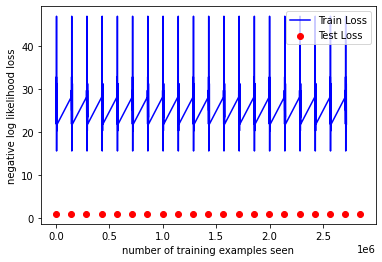

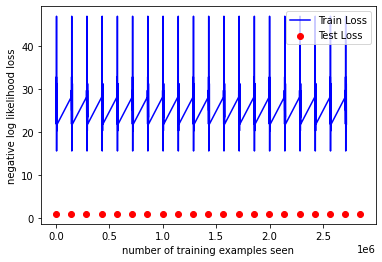

In [53]:
fig = plt.figure()
plt.plot(update_train_counter, update_train_losses, color='blue')
plt.scatter(update_test_counter, update_test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [54]:
h2.eval()
h1.eval()

LogisticRegression(
  (linear): Linear(in_features=105, out_features=1, bias=True)
)

In [55]:
test_index = 2

In [56]:
with torch.no_grad():
    h1_output_sigmoid = h1(test_loader[test_index][0])
    h2_output_sigmoid = h2(test_loader[test_index][0])

In [57]:
h1_labels = utils.sigmoid_to_labels(h1_output_sigmoid, discriminant_pivot=discriminant_pivot)
h2_labels = utils.sigmoid_to_labels(h2_output_sigmoid, discriminant_pivot=discriminant_pivot)
expected_labels = test_loader[test_index][1]

In [58]:
trust_compatibility = scores.trust_compatibility_score(h1_labels, h2_labels, expected_labels)
error_compatibility = scores.error_compatibility_score(h1_labels, h2_labels, expected_labels)

print(f"Error Compatibility Score: {error_compatibility}")
print(f"Trust Compatibility Score: {trust_compatibility}")

Error Compatibility Score: 1.0
Trust Compatibility Score: 1.0
